# Fit and predict using pib features and logistic regression

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load data 

In [3]:
files_df = pd.read_pickle('./processed_data/files_df.pkl')
files_df.head()

,dir_name,file_name,path,patient,preictal,train,pib_3,pib_2,pib_1
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0,848777,1897922,511194
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0,1805838,1484367,216014
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0,1241170,1900609,284337
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0,1743604,1513067,231791
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0,2139217,1235885,187611


## Extract useful data

In [11]:
meta_df = files_df.set_index('file_name')
meta_df = meta_df.loc[:,'patient':]
meta_df.head()

,patient,preictal,train,pib_3,pib_2,pib_1
file_name,,,,,,
1_1.mat,1,-1,0,848777,1897922,511194
1_10.mat,1,-1,0,1805838,1484367,216014
1_100.mat,1,-1,0,1241170,1900609,284337
1_1000.mat,1,-1,0,1743604,1513067,231791
1_1001.mat,1,-1,0,2139217,1235885,187611


In [24]:
# Train data
X_train = meta_df[meta_df['train']==1]
y_train = meta_df[meta_df['train']==1]['preictal']
X_train = X_train.drop(['train','preictal'], axis=1)
display(X_train.head())
display(y_train.head())

,patient,pib_3,pib_2,pib_1
file_name,,,,
1_1000_0.mat,1,789192,2056416,481576
1_1001_0.mat,1,824351,1985675,485730
1_1002_0.mat,1,945059,2082889,396960
1_1003_0.mat,1,796860,2068275,432816
1_1004_0.mat,1,997601,1962371,409753


file_name
1_1000_0.mat    0
1_1001_0.mat    0
1_1002_0.mat    0
1_1003_0.mat    0
1_1004_0.mat    0
Name: preictal, dtype: int64

In [25]:
# Test data
X_test = meta_df[meta_df['train']==0]
X_test = X_test.drop(['train','preictal'], axis=1)
display(X_test.head())

,patient,pib_3,pib_2,pib_1
file_name,,,,
1_1.mat,1,848777,1897922,511194
1_10.mat,1,1805838,1484367,216014
1_100.mat,1,1241170,1900609,284337
1_1000.mat,1,1743604,1513067,231791
1_1001.mat,1,2139217,1235885,187611


## Define pipeline and cross validation model fitting

In [33]:
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline =  GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

In [34]:
%%time
cv_pipeline.fit(X=X_train, y=y_train)

CPU times: user 2.21 s, sys: 35.1 ms, total: 2.24 s
Wall time: 1.18 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0....     penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__l1_ratio': [0, 0.2, 0.8, 1], 'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [35]:
print('{:.3%}'.format(cv_pipeline.best_score_))
print(cv_pipeline.best_params_)

62.666%
{'classify__l1_ratio': 0.2, 'classify__loss': 'log', 'classify__penalty': 'elasticnet', 'classify__alpha': 0.1}


In [89]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.014374,0.002717,0.429794,0.583047,0.001,0,log,elasticnet,"{'classify__l1_ratio': 0, 'classify__loss': 'l...",15,...,0.499124,0.612330,0.002139,0.000673,0.101997,0.084880,0.001,0.0,log,elasticnet
1,0.012741,0.001972,0.438850,0.588584,0.001,0.2,log,elasticnet,"{'classify__l1_ratio': 0.2, 'classify__loss': ...",14,...,0.498544,0.612222,0.000350,0.000113,0.109617,0.075258,0.001,0.2,log,elasticnet


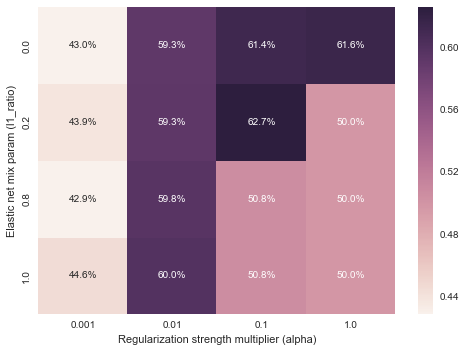

In [42]:
# Cross-validated performance heatmap
ax = plt.figure()
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')

ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mix param (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [44]:
def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

y_pred_train = cv_pipeline.decision_function(X_train)
metrics_train = get_threshold_metrics(y_train, y_pred_train)

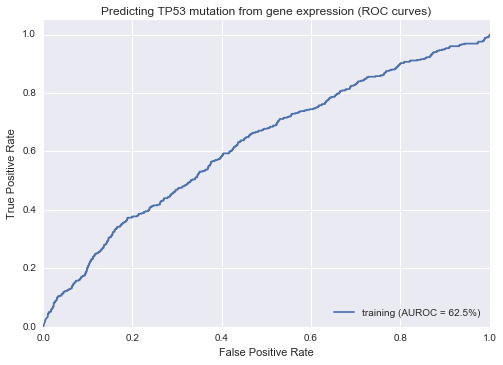

In [46]:
roc_df = metrics_train['roc_df']
plt.plot(roc_df.fpr, roc_df.tpr,
label='{} (AUROC = {:.1%})'.format('training', metrics_train['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Predict test ictal status and save as csv

In [90]:
y_pred_test = cv_pipeline.predict(X_test)
output_df = pd.DataFrame({'File':X_test.index.values, 'Class': y_pred_test})
output_df = output_df[['File','Class']]
output_df.to_csv('./submissions/submission_4.csv',index=False)
output_df.head()

,File,Class
0,1_1.mat,0
1,1_10.mat,1
2,1_100.mat,0
3,1_1000.mat,1
4,1_1001.mat,1
